# Assignment 6: Neural Networks

# Problem 1: The dataset

Loading the MNIST dataset from `torchvision.datasets`:

In [46]:
import torch
from numba.core.ir import Print
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
	root='data',
	train=True,
	download=True,
	transform=ToTensor()
)

test_data = datasets.MNIST(
	root='data',
	train=False,
	download=True,
	transform=ToTensor()
)

Wrapping the dataset in a `DataLoader`:

In [47]:
train_loader = DataLoader(
	train_data,
	batch_size=64,
)

test_loader = DataLoader(
	test_data,
	batch_size=64,
)

Plotting the first images from the training set:

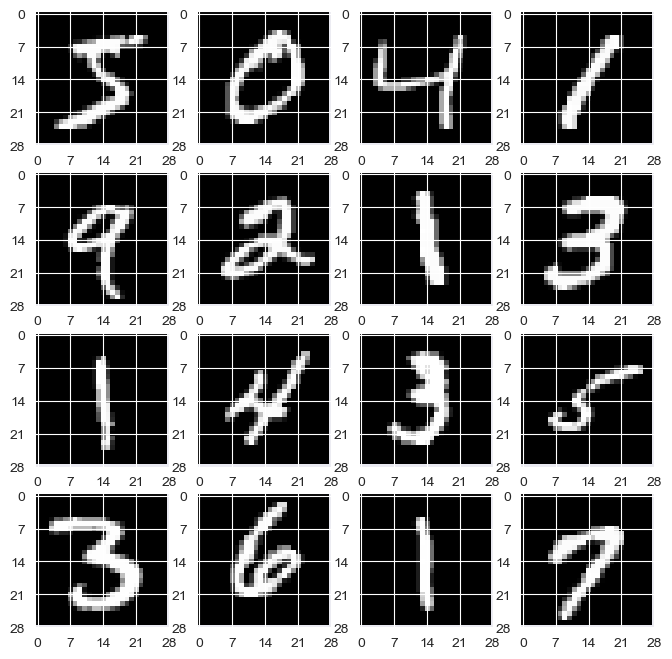

In [48]:
import matplotlib.pyplot as plt

images, _ = next(iter(train_loader))

ppr = 4  # plots per row

fig, ax = plt.subplots(
	ppr, ppr,
	figsize=(ppr * 2, ppr * 2)
)
for i in range(ppr ** 2):
	ax[i // ppr, i % ppr].imshow(
		images[i].squeeze(),
		cmap='gray'
	)
	ax[i // ppr, i % ppr].set_xticks(
		range(0, 29, 7))
	ax[i // ppr, i % ppr].set_yticks(
		range(0, 29, 7))

plt.savefig('figures/mnist.png')

# Problem 2: Single hidden layer

Creating the model for a single hidden layer with ReLU activation:

In [49]:
device = (
	"cuda"
	if torch.cuda.is_available()
	else "mps"
	if torch.backends.mps.is_available()
	else "cpu"
)
print(f"Using device: {device}")


class NeuralNetwork(nn.Module):
	def __init__(self):
		super().__init__()
		self.flatten = nn.Flatten()
		self.linear_relu_stack = nn.Sequential(
			nn.Linear(28 * 28, 512),
			nn.ReLU(),
			nn.Linear(512, 10),
		)

	def forward(self, x):
		x = self.flatten(x)
		logits = self.linear_relu_stack(x)
		return logits


model = NeuralNetwork().to(device)

Using device: mps


Defining the training of the model using the SGD optimizer and CrossEntropy loss:

In [50]:
lr = 1e-3

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
	model.parameters(), lr=lr
)

In [51]:
def train(dataloader, model, loss_fn, optimizer):
	size = len(dataloader.dataset)
	model.train()
	for batch, (X, y) in enumerate(dataloader):
		X, y = X.to(device), y.to(device)

		pred = model(X)
		loss = loss_fn(pred, y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		if batch % 100 == 0:
			loss, current = loss.item(), batch * len(X)
			print(
				f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Defining the testing of the model performance against the `test_data`:

In [52]:
def test(dataloader, model, loss_fn):
	size = len(dataloader.dataset)
	num_batches = len(dataloader)
	model.eval()
	test_loss, correct = 0, 0
	with (torch.no_grad()):
		for X, y in dataloader:
			X, y = X.to(device), y.to(device)
			pred = model(X)
			test_loss += loss_fn(pred, y).item()
			correct += (
					pred.argmax(1) == y
			).type(torch.float).sum().item()
	test_loss /= num_batches
	correct /= size
	print(
		f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
	)

Training the model for 10 epochs and evaluating its performance:

In [53]:
epochs = 10
for t in range(epochs):
	print(
		f"Epoch {t + 1}\n-------------------------------")
	train(train_loader, model, loss_fn, optimizer)
	test(test_loader, model, loss_fn)

Epoch 1
-------------------------------
loss: 2.306453  [    0/60000]
loss: 2.282830  [ 6400/60000]
loss: 2.254412  [12800/60000]
loss: 2.228440  [19200/60000]
loss: 2.209880  [25600/60000]
loss: 2.191260  [32000/60000]
loss: 2.155684  [38400/60000]
loss: 2.170841  [44800/60000]
loss: 2.103606  [51200/60000]
loss: 2.076698  [57600/60000]
Test Error: 
 Accuracy: 67.6%, Avg loss: 2.073582 

Epoch 2
-------------------------------
loss: 2.069210  [    0/60000]
loss: 2.033675  [ 6400/60000]
loss: 2.051940  [12800/60000]
loss: 1.929651  [19200/60000]
loss: 1.961879  [25600/60000]
loss: 1.946249  [32000/60000]
loss: 1.872621  [38400/60000]
loss: 1.945324  [44800/60000]
loss: 1.821477  [51200/60000]
loss: 1.784107  [57600/60000]
Test Error: 
 Accuracy: 74.0%, Avg loss: 1.780254 

Epoch 3
-------------------------------
loss: 1.781705  [    0/60000]
loss: 1.714808  [ 6400/60000]
loss: 1.773721  [12800/60000]
loss: 1.589878  [19200/60000]
loss: 1.640293  [25600/60000]
loss: 1.625985  [32000/600

Saving the model to a file:

In [54]:
torch.save(model.state_dict(), "models/single_layer.pth")
print("Saved PyTorch Single Layer Model state to single_layer.pth")

Saved PyTorch Single Layer Model state to single_layer.pth


# Problem 3: Two hidden layers

Redeclaring the model with two hidden layers:

In [55]:
class NeuralNetwork(nn.Module):
	def __init__(self):
		super().__init__()
		self.flatten = nn.Flatten()
		self.linear_relu_stack = nn.Sequential(
			nn.Linear(28 * 28, 500),
			nn.ReLU(),
			nn.Linear(500, 300),
			nn.ReLU(),
			nn.Linear(300, 10),
		)

	def forward(self, x):
		x = self.flatten(x)
		logits = self.linear_relu_stack(x)
		return logits
	
model = NeuralNetwork().to(device)

Redefine the optimizer with L2 regularization:

In [56]:
weight_decay = 1e-5

optimizer = torch.optim.SGD(
	model.parameters(), 
	lr=lr, 
	weight_decay=weight_decay
)

Train the model for 40 epochs and evaluate its performance:

In [57]:
epochs = 40

for t in range(epochs):
	print(
		f"Epoch {t + 1}\n-------------------------------")
	train(train_loader, model, loss_fn, optimizer)
	test(test_loader, model, loss_fn)

Epoch 1
-------------------------------
loss: 2.295860  [    0/60000]
loss: 2.291108  [ 6400/60000]
loss: 2.313885  [12800/60000]
loss: 2.284321  [19200/60000]
loss: 2.298410  [25600/60000]
loss: 2.285083  [32000/60000]
loss: 2.276171  [38400/60000]
loss: 2.273756  [44800/60000]
loss: 2.269361  [51200/60000]
loss: 2.274746  [57600/60000]
Test Error: 
 Accuracy: 23.6%, Avg loss: 2.263995 

Epoch 2
-------------------------------
loss: 2.254333  [    0/60000]
loss: 2.247833  [ 6400/60000]
loss: 2.275972  [12800/60000]
loss: 2.230259  [19200/60000]
loss: 2.253551  [25600/60000]
loss: 2.241959  [32000/60000]
loss: 2.223426  [38400/60000]
loss: 2.231076  [44800/60000]
loss: 2.215263  [51200/60000]
loss: 2.216798  [57600/60000]
Test Error: 
 Accuracy: 43.9%, Avg loss: 2.207805 

Epoch 3
-------------------------------
loss: 2.197967  [    0/60000]
loss: 2.187601  [ 6400/60000]
loss: 2.225048  [12800/60000]
loss: 2.151423  [19200/60000]
loss: 2.187696  [25600/60000]
loss: 2.174830  [32000/600

Save the model to a file:

In [58]:
torch.save(model.state_dict(), "models/two_layer.pth")
print("Saved PyTorch Two Layer Model state to two_layer.pth")

Saved PyTorch Two Layer Model state to two_layer.pth
